# Data Analysis for Business, Economics, and Policy
---
## Assignment 2: Data Prep
Ambrus Fodor, Katharina Burtscher


In [261]:
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Import data & Sample Design

In [ ]:

data = pd.read_csv("https://raw.githubusercontent.com/4mbrus/Data-Analysis-3/refs/heads/main/Assignment%202/data/cs_bisnode_panel.csv")


In [ ]:
#Data exploration
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
display(data.head())
data.info()


Dataset contains 287829 rows and 48 columns.


,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

In [264]:
# Get the sets of unique company IDs for each year
ids_2012 = set(data.loc[data["year"] == 2012, "comp_id"])
ids_2013 = set(data.loc[data["year"] == 2013, "comp_id"])

# Find the intersection (companies present in both years)
common_ids = ids_2012.intersection(ids_2013)

data = data[data["comp_id"].isin(common_ids)]

data.isna().sum()

comp_id                      0
begin                        0
end                          0
COGS                    209798
amort                     4938
curr_assets                 71
curr_liab                   71
extra_exp                13866
extra_inc                13866
extra_profit_loss        13472
finished_prod           210408
fixed_assets                71
inc_bef_tax               4453
intang_assets               79
inventories                 71
liq_assets                  71
material_exp              4938
net_dom_sales           209798
net_exp_sales           209798
personnel_exp             4938
profit_loss_year          9078
sales                     4453
share_eq                    71
subscribed_cap              71
tang_assets                475
wages                   210020
D                       224766
balsheet_flag                0
balsheet_length              0
balsheet_notfullyear         0
year                         0
founded_year             36790
exit_yea

In [265]:
# drop variables with many NAs
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages", "D", "exit_year", "exit_date"]
)



# Label engineering (& Sample Design still)


In [266]:
data = data.sort_values(['comp_id', 'year'])

# We group by comp_id to ensure we don't accidentally pull sales from a different firm
data['sales_growth'] = data.groupby('comp_id')['sales'].pct_change(periods=1)

#drop nan in sales_growth
data = data.dropna(subset="sales_growth")

In [267]:
data["sales"].isna().sum()

np.int64(938)

##### Defining "fast growth"
- Potential outcome variables:
    - curr_assets "Current assets"
    - fixed_assets "fixed assets"
    - inc_bef_tax "income before tax"
    - profit_loss_year "profit/loss, annual"
    - sales "total sales"

- In the end we decided to go with *sales* beacuse:
    - *profit_loss_year* can not capture the growth of rapidly expanding companies, which keep their profits low to buy new equipment/hire new people
    - the change in assests discriminate against certain industires like tech/service sector, which don't have expensive assets
    - *inc_bef_tax* in finance income already has expenses deducted, so the problem is the same as with *profit_loss_year*
    - *sales* is a straight forward measure: every company is selling something be that a product or a service. Even start-ups which are backed by venture capital funds have usually fast growing sales eventough they are loosing money (think about the AI boom)
- The functional form
    - We have decided to take the percentage growth in sales between 2012 and 2013 by taking simply the percentage difference between the values for the dates. We choose to take values from 2012 and 2013, because more data was available for those.
    - We also have to decide on a cut-off: From which growth rate can we call a company fast growing?
        - According to some definitions a firm is fast growing if it grows at least by 20% for 3 consecutive years
        - Based on this, a histogram, and the fact we are only looking at growth over 1 year, we are going to be stricter, and say that:
            -  **Fast growing firms are those that achieved 30% growth in a year**




In [268]:
data["sales"].describe()


count    1.765100e+05
mean     6.255274e+05
std      3.947257e+06
min     -9.232593e+04
25%      1.601481e+04
50%      5.455926e+04
75%      1.779176e+05
max      1.099510e+08
Name: sales, dtype: float64

In [269]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [270]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)


In [271]:
data["new"].describe()


count    155049.000000
mean          0.069204
std           0.253801
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: new, dtype: float64

In [272]:
#drop firms which had missing sales for 2012
missing_in_12 = data.loc[(data["year"] == 2012) & (data["sales"].isnull()), "comp_id"]
data = data[~data["comp_id"].isin(missing_in_12)]
# look at firms below 10m euro revenues and above 10000
outside_treshold_in_12 = data.loc[(data["year"] == 2012) & ((data["sales_mil"] >= 10) | (data["sales_mil"] <= 0.01)), "comp_id"] 
data = data[~data["comp_id"].isin(outside_treshold_in_12)]
#keep data for year of interest, and where sales_growth is not infinite
data = data[(data["year"] == 2013) & (np.abs(data["sales_growth"]) != np.inf)]

In [303]:
data = data[ (data["sales_growth"] >= -1)& (data["sales_growth"] < 10)] #limit extreme and abnormal values
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
data["sales_growth"].describe()

Dataset contains 15231 rows and 108 columns.


count    15231.000000
mean         0.182687
std          1.017595
min         -1.000000
25%         -0.210725
50%          0.019275
75%          0.262434
max          9.934632
Name: sales_growth, dtype: float64

In [ ]:
#Define cutoff
cutoff = 0.3

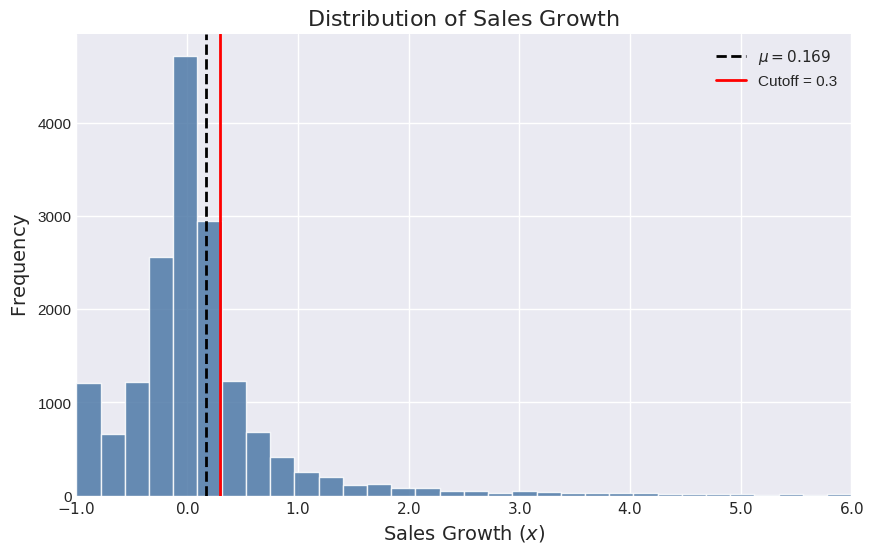

In [276]:
plt.style.use('seaborn-v0_8-darkgrid') 
plt.figure(figsize=(10, 6))

counts, bins, patches = plt.hist(
    data["sales_growth"], 
    bins=50, 
    color='#4e79a7', 
    edgecolor='white', 
    alpha=0.85
)

x_min, x_max = data["sales_growth"].min(), data["sales_growth"].max()
tick_start = np.floor(x_min * 10) / 10
tick_end = np.ceil(x_max * 10) / 10
ticks = np.arange(tick_start, tick_end + 0.1, 1)

plt.xticks(ticks, [f"${t:.1f}$" for t in ticks])

plt.title(r'$\text{Distribution of Sales Growth}$', fontsize=16)
plt.xlabel(r'$\text{Sales Growth } (x)$', fontsize=14)
plt.ylabel(r'$\text{Frequency}$', fontsize=14)

mean_val = data["sales_growth"].mean()
plt.axvline(mean_val, color='black', linestyle='--', linewidth=2, 
            label=rf'$\mu = {mean_val:.3f}$')

plt.axvline(0.3, color='red', linestyle='-', linewidth=2, 
            label=f'Cutoff = {cutoff}')
plt.xlim(-1,6)
plt.legend()

In [277]:
data["is_fast_growing"] = np.where(data["sales_growth"] >= 0.3, 1, 0)

# Feature engineering

In [278]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])


In [279]:
data.groupby("ind2_cat").count()["comp_id"]


ind2_cat
20.0      42
26.0     895
27.0     558
28.0    1702
29.0     244
30.0     135
32.0     114
33.0    1626
40.0     175
55.0    1674
56.0    9709
60.0     172
99.0       4
Name: comp_id, dtype: int64

In [280]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [281]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    17037
1.0       12
Name: comp_id, dtype: int64

In [282]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [283]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    1.704900e+04
mean     3.363511e+05
std      2.038845e+06
min      0.000000e+00
25%      9.648148e+03
50%      3.408148e+04
75%      1.357741e+05
max      1.594840e+08
Name: total_assets_bs, dtype: float64

In [284]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]


In [285]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


In [286]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [287]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [288]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [289]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [290]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [291]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [292]:
data["labor_avg"].describe()


count    14314.000000
mean         0.734825
std          1.775876
min          0.083333
25%          0.138889
50%          0.263889
75%          0.618056
max         40.916668
Name: labor_avg, dtype: float64

In [293]:
data["labor_avg_mod"].describe()


count    17050.000000
mean         0.734825
std          1.627153
min          0.083333
25%          0.166667
50%          0.361111
75%          0.734825
max         40.916668
Name: labor_avg_mod, dtype: float64

In [294]:
data = data.drop(["labor_avg"], axis=1)


In [295]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")


In [296]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


In [297]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])


In [298]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    15231.000000
mean         9.691156
std          7.008133
min          0.000000
25%          3.000000
50%          8.000000
75%         16.000000
max         62.000000
Name: age, dtype: float64

In [299]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()


In [300]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

Dataset contains 15231 rows and 108 columns.


In [301]:
data.to_csv("bisnode_firms_clean.csv", index=False)
